#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [ ]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 4s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [ ]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

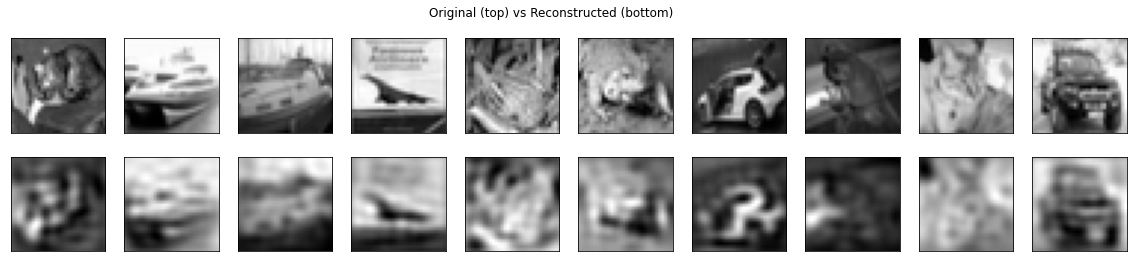

In [ ]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_

When I changed the `ENCODING_DIM` I tried several possible values:

- For the first case (`ENCODING_DIM` = 30) I obtained a Training mse of 0.01017 and a Test mse pf 0.01021, also the quality of the compressed images is really low and it is really difficult to understand what's in the figure.

- For the second case (`ENCODING_DIM` = 60) I obtained a Training mse of 0.00658 and a Test mse of 0.00661. The quality of the compressed images is really bad, the images seem blurred.

- For the third case (`ENCODING_DIM` = 240) I obtained a Training mse of 0.00165 and a Test mse of 0.00168. The quality of the compressed images is quite good and it is possible to understand what's in it.

- For the fourth case ((`ENCODING_DIM` = 480)) I obtained a Training mse of 0.00044 and a Test mse of 0.00045, the differences between the originals and the compressed are imperceptible or really reduced.

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 8ms/step - loss: 0.2094 - val_loss: 0.0314
Epoch 2/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0256 - val_loss: 0.0215
Epoch 3/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0189 - val_loss: 0.0169
Epoch 4/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0193 - val_loss: 0.0141
Epoch 5/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0122
Epoch 6/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 7/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 8/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 9/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 10/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 11/15
79/79 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0060 - 502ms/epoch - 2ms/step
Test mse: 0.00602


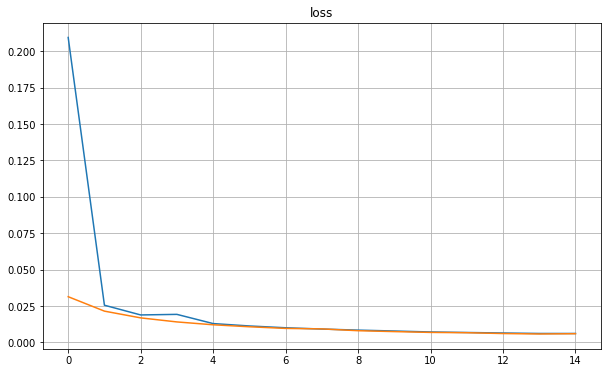

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

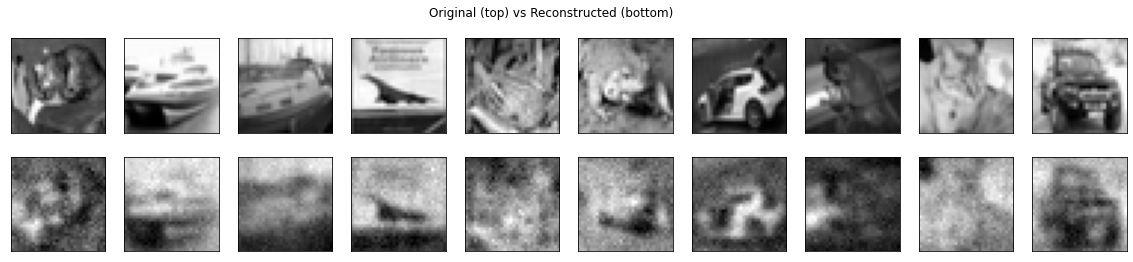

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_

In the SVD decomposition initialized with `ENCODING_DIM` = 120, we have obtained a Training mse of 0.00372 and a Test mse of 0.00375. 

In this linear model initialized with `ENCODING_DIM` = 256, we obtained a loss on the training set of 0.00570 and a loss on the test set of 0.00558.

The two models have similar loss, so basically we can say that the linear autoencoder is learning what SVD does. Moreover, the SVD images are more clear than the noisy one in the linear model, but still we can understand the subject.

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.0350 - val_loss: 0.0225
Epoch 2/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 0.0164
Epoch 3/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0167 - val_loss: 0.0139
Epoch 4/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0124
Epoch 5/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 6/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 7/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 8/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0114
Epoch 9/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 10/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 11/15
79/79 [

313/313 - 1s - loss: 0.0077 - 515ms/epoch - 2ms/step
Test mse: 0.00772


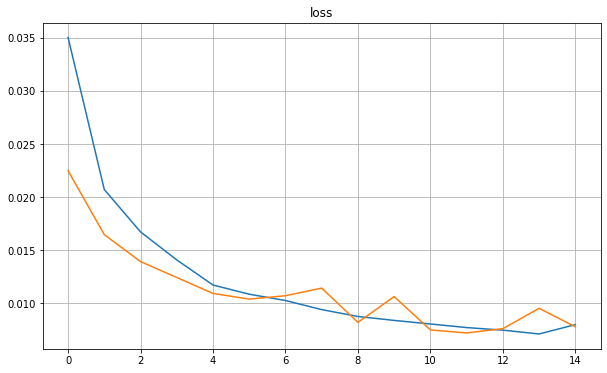

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

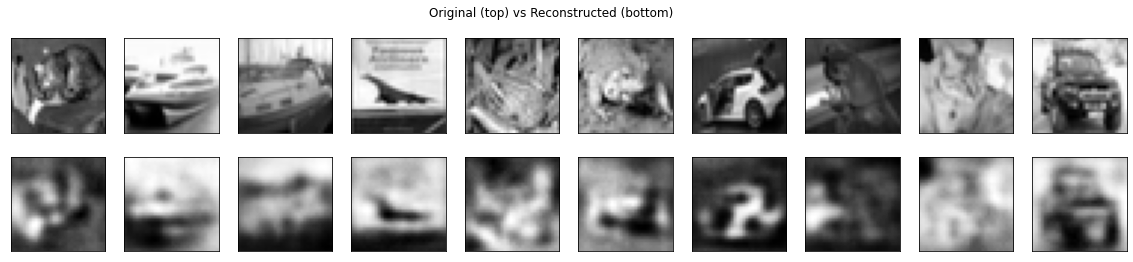

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**Discussion:**

I've chosen the $sigmoid$ activation function because it works better than the 'relu' function, which gives decoded images with strange noisy black dots, while the $sigmoid $ function gives us better compressed images, but quite blurred.

I obtained a test loss of 0.00772 while the loss in Exercise 5.2 was 0.00602. So the results are very similar.

The quality of the compressed images are less noisy compared to the ones in Exercise 5.2, but as said before they are more blurred.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]
encoded = tf.keras.layers.Dense(units=INPUT_DIM, activation='sigmoid')(input_img)
encoded = tf.keras.layers.Dense(units=128, activation='sigmoid')(encoded)
encoded = tf.keras.layers.Dense(units=64, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(units=32, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(units=64, activation='sigmoid')(decoded)
decoded = tf.keras.layers.Dense(units=128, activation='sigmoid')(decoded)
decoded = tf.keras.layers.Dense(units=INPUT_DIM, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 128)               131200    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 128)               8320

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 256, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
157/157 [==============================] - 2s 7ms/step - loss: 0.0488 - val_loss: 0.0421
Epoch 2/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0407 - val_loss: 0.0402
Epoch 3/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0382 - val_loss: 0.0335
Epoch 4/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0326 - val_loss: 0.0320
Epoch 5/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0320 - val_loss: 0.0318
Epoch 6/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0318 - val_loss: 0.0320
Epoch 7/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 0.0318
Epoch 8/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0315 - val_loss: 0.0297
Epoch 9/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0282 - val_loss: 0.0279
Epoch 10/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0277 - val_loss: 0.0277

313/313 - 1s - loss: 0.0273 - 554ms/epoch - 2ms/step
test mse: 0.02730


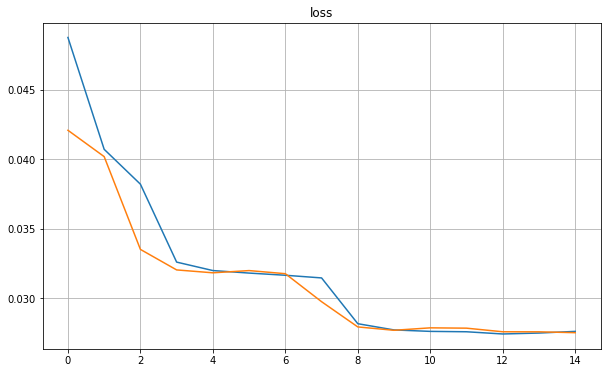

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

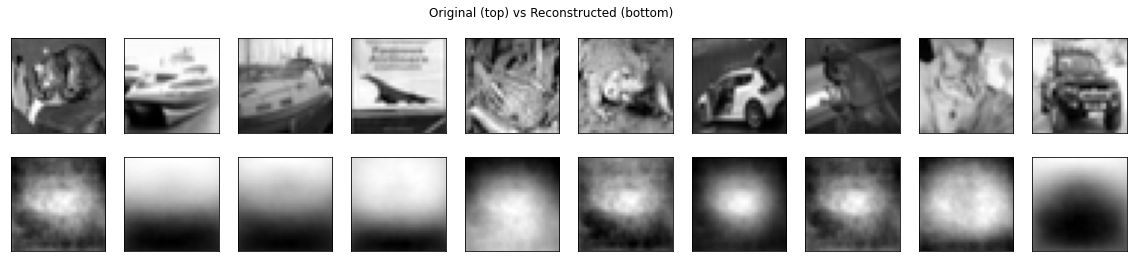

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

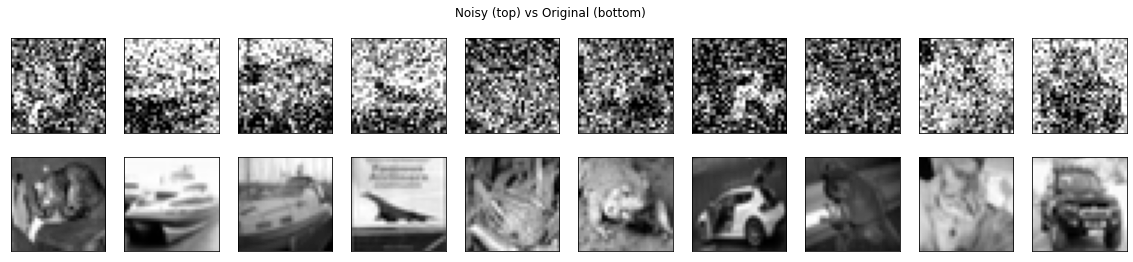

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
noise_factor = 0.4

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]
encoded = tf.keras.layers.Dense(128, activation='sigmoid')(input_img)

decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)


autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_13 (Dense)            (None, 128)               131200    
                                                                 
 dense_14 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 15, batch_size= 256, shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/15
157/157 [==============================] - 1s 5ms/step - loss: 0.0338 - val_loss: 0.0226
Epoch 2/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0214 - val_loss: 0.0189
Epoch 3/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0179 - val_loss: 0.0201
Epoch 4/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0175 - val_loss: 0.0165
Epoch 5/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 6/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 7/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 8/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 9/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 10/15
157/157 [==============================] - 1s 4ms/step - loss: 0.0144 - val_loss: 0.0166

313/313 - 1s - loss: 0.0151 - 513ms/epoch - 2ms/step
Test mse: 0.01514


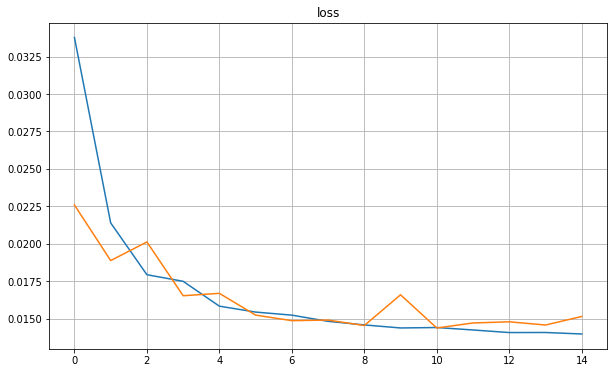

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

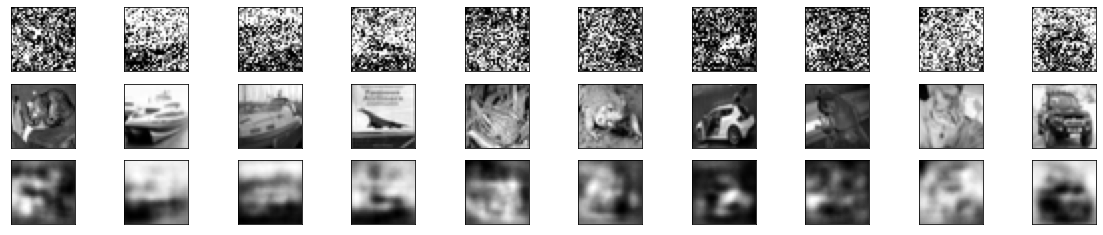

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

**Discussion:**

I can observe that the higher the noise value, the worst the capability of my model. This fact is probably due to the fact that there are only one layer which denoise the images. In the decoded images it is possible to understand the shape of the subject in the image (noise = 0.4).

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 7s 72ms/step - loss: 0.2287 - categorical_accuracy: 0.0841 - val_loss: 0.1032 - val_categorical_accuracy: 0.2301
Epoch 2/50
79/79 [==============================] - 5s 68ms/step - loss: 0.0813 - categorical_accuracy: 0.3815 - val_loss: 0.0675 - val_categorical_accuracy: 0.4685
Epoch 3/50
79/79 [==============================] - 5s 68ms/step - loss: 0.0604 - categorical_accuracy: 0.5150 - val_loss: 0.0562 - val_categorical_accuracy: 0.5376
Epoch 4/50
79/79 [==============================] - 5s 69ms/step - loss: 0.0511 - categorical_accuracy: 0.5628 - val_loss: 0.0485 - val_categorical_accuracy: 0.5635
Epoch 5/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0455 - categorical_accuracy: 0.5950 - val_loss: 0.0448 - val_categorical_accuracy: 0.5963
Epoch 6/50
79/79 [==============================] - 5s 69ms/step - loss: 0.0408 - categorical_accuracy: 0.6208 - val_loss: 0.0381 - val_categorical_accuracy: 0.6258
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0070 - categorical_accuracy: 0.9660 - 357ms/epoch - 9ms/step
categorical_accuracy: 96.60%


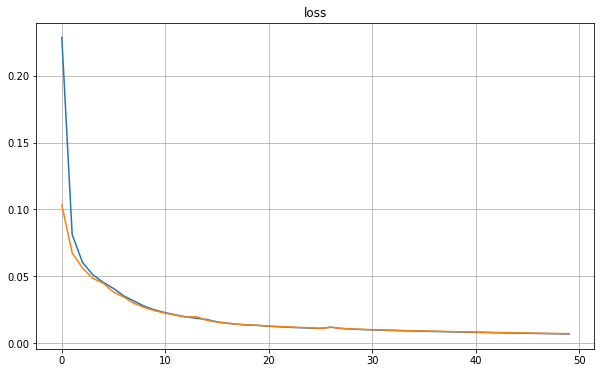

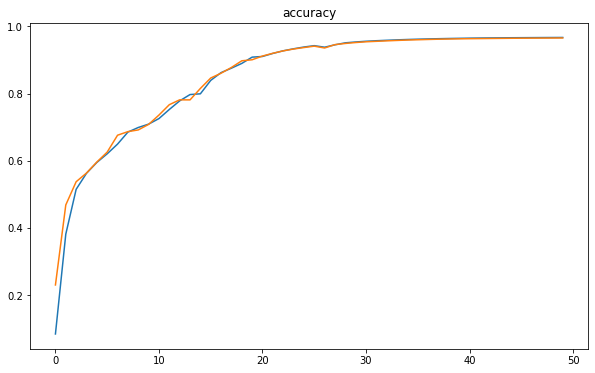

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some all <oov> about <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> a <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_1 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 14s 159ms/step - loss: 0.0427 - categorical_accuracy: 0.4156 - val_loss: 0.0371 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 12s 153ms/step - loss: 0.0362 - categorical_accuracy: 0.4710 - val_loss: 0.0361 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 13s 159ms/step - loss: 0.0347 - categorical_accuracy: 0.4710 - val_loss: 0.0338 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 12s 155ms/step - loss: 0.0316 - categorical_accuracy: 0.4710 - val_loss: 0.0300 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 12s 156ms/step - loss: 0.0274 - categorical_accuracy: 0.4775 - val_loss: 0.0254 - val_categorical_accuracy: 0.5139
Epoch 6/50
79/79 [==============================] - 12s 155ms/step - loss: 0.0227 - categorical_accuracy: 0.6243 - val_loss: 0.0206 - val_categorical_accuracy: 0.723

40/40 - 1s - loss: 3.3405e-05 - categorical_accuracy: 1.0000 - 516ms/epoch - 13ms/step
categorical_accuracy: 100.00%


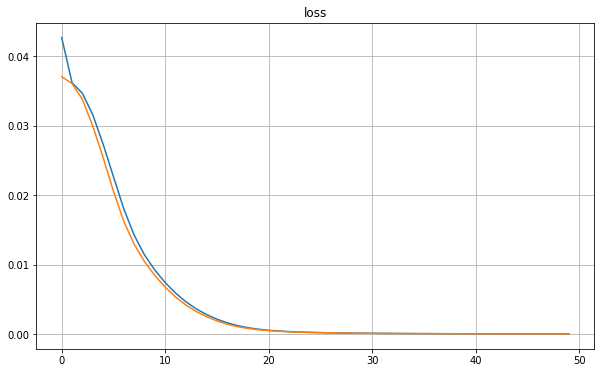

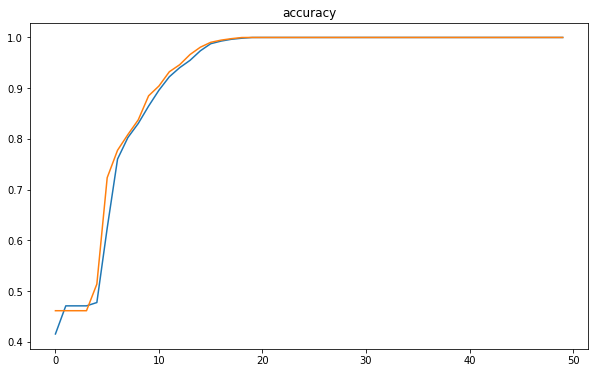

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


**Discussion:**

I tried several combination of non-linear activation function and I get that the combination of $sigmoid$ and $softmax$ for, respectively, the LSTM layer and the Dense layer, helped me to get an accuracy on the test set of 100%, that is greater than 96.60% of the model with a SimpleRNN layer and linear activation. The choise of the $softmax$ activation function is a good choise because it performs better than the other functions tested.

The model does not overfit as seen in the plot of the loss above. 
